In [1]:
cd /content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 AI 경진대회 태양광 | 한국동서발전(주) | 개인 스타트업 | 시계열 | NMAE/data

/content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 AI 경진대회 태양광 | 한국동서발전(주) | 개인 스타트업 | 시계열 | NMAE/data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dangjin_fcst = pd.read_csv('dangjin_fcst_data.csv')

In [5]:
dangjin_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,7.0,40.0,3.2,187.0,1.0
162204,2021-03-01 08:00:00,55.0,8.0,40.0,4.5,217.0,1.0
162205,2021-03-01 08:00:00,58.0,5.0,55.0,2.2,210.0,1.0
162206,2021-03-01 08:00:00,61.0,1.0,80.0,1.9,164.0,1.0


예보 시간 컬럼의 데이터 타입을 datetime으로 변경합니다

In [7]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])

기상청에서는 하루 3시간 간격으로 8회 예보합니다.

여기서는 14시 예보만을 사용하였습니다.

In [8]:
fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14]

다음 날의 기상 예보가 필요하여 예보시간 기준 10시간 후(00:00)부터 33시간 후(23:00) 데이터만 사용합니다.

In [9]:
fcst_14 = fcst_14[(fcst_14['forecast']>=10)&(fcst_14['forecast']<=33)]

예보 시점에 focast를 더하여 예보 시각을 구합니다.

In [10]:
def to_date(x):
    return pd.DateOffset(hours=x)

fcst_14['Forecast_time'] = fcst_14['Forecast_time'] + fcst_14['forecast'].map(to_date)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [11]:
fcst_14 = fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [12]:
fcst_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
22,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
23,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
24,2018-03-02 06:00:00,-5.0,60.0,4.3,344.0,1.0
25,2018-03-02 09:00:00,-2.0,55.0,2.0,345.0,1.0
26,2018-03-02 12:00:00,1.0,45.0,0.8,256.0,1.0
...,...,...,...,...,...,...
162085,2021-03-01 09:00:00,8.0,90.0,3.9,64.0,4.0
162086,2021-03-01 12:00:00,10.0,90.0,4.8,7.0,4.0
162087,2021-03-01 15:00:00,10.0,85.0,6.6,11.0,4.0
162088,2021-03-01 18:00:00,7.0,85.0,6.5,34.0,4.0


태양광 발전량 예측은 1시간 간격으로 해야하나 예보는 3시간 간격으로 나옵니다.

간단한 선형보간법을 활용하여 비어있는 값을 채우겠습니다.

우선 한시간 간격의 데이터프레임을 생성하고

In [13]:
fcst_14_ = pd.DataFrame()
fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [14]:
fcst_14_

,Forecast_time
0,2018-03-02 00:00:00
1,2018-03-02 01:00:00
2,2018-03-02 02:00:00
3,2018-03-02 03:00:00
4,2018-03-02 04:00:00
...,...
26299,2021-03-01 19:00:00
26300,2021-03-01 20:00:00
26301,2021-03-01 21:00:00
26302,2021-03-01 22:00:00


기존 예보 데이터프레임과 병합합니다.

In [15]:
fcst_14_ = pd.merge(fcst_14_, fcst_14, on='Forecast_time', how='outer')

병합 후 중간 값이 비어있는 것을 확인 할 수 있습니다.

In [16]:
fcst_14_

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,NaN,NaN,NaN,NaN,NaN
26300,2021-03-01 20:00:00,NaN,NaN,NaN,NaN,NaN
26301,2021-03-01 21:00:00,5.0,85.0,5.9,27.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


pandas에서 지원하는 interpolate함수를 활용하여 선형보간합니다.

In [17]:
inter_fcst_14 = fcst_14_.interpolate()

In [18]:
inter_fcst_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.333333,85.000000,6.3,31.666667,4.0
26300,2021-03-01 20:00:00,5.666667,85.000000,6.1,29.333333,4.0
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0
26302,2021-03-01 22:00:00,5.000000,85.000000,5.9,27.000000,4.0


보간 결과 시각화

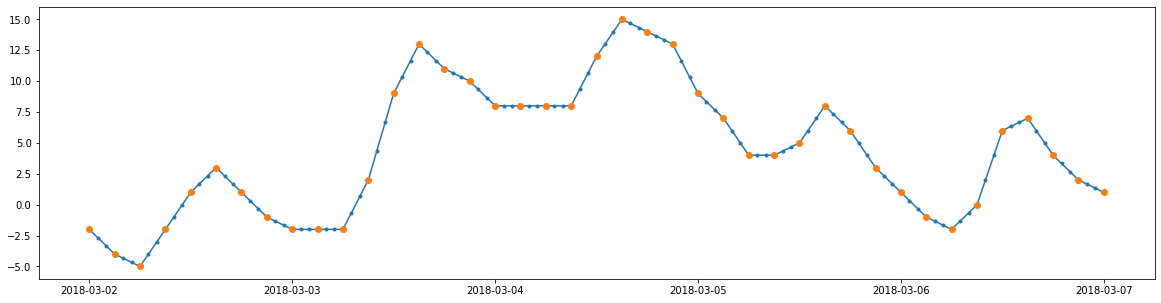

In [19]:
plt.figure(figsize=(20,5))
days = 5
plt.plot(inter_fcst_14.loc[:24*days, 'Forecast_time'], inter_fcst_14.loc[:24*days, 'Temperature'], '.-')
plt.plot(fcst_14_.loc[:24*days, 'Forecast_time'], fcst_14_.loc[:24*days, 'Temperature'], 'o')

In [21]:
inter_fcst_14.to_csv('dangjin_fcst_liner_bogan.csv', index=False)